# Snakemake

```{note}

This notebook serves as a demo for Python scripting that you could run before and after Snakemake runs.

Typically, you'd run workflows from the command line or cloud solutions.
```

[Snakemake](https://snakemake.readthedocs.io/en/stable/) is a workflow manager for executing scientific workflows across platforms scalably, portably, and reproducibly.
Here, we’ll run `snakemake-workflows/rna-seq-star-deseq2` to perform differential gene expression analysis with STAR and deseq2 ([reference](https://github.com/snakemake-workflows/rna-seq-star-deseq2)).

Let’s create a test instance:

In [1]:
!lamin init --storage . --name snakemake-bulkrna

→ initialized lamindb: zethson/snakemake-bulkrna


In [2]:
import lamindb as ln

→ connected lamindb: zethson/snakemake-bulkrna


## Download test data

The Snakemake pipeline comes with test data.
Therefore, we clone the whole pipeline using git:

In [20]:
!git clone https://github.com/snakemake-workflows/rna-seq-star-deseq2 --single-branch --branch v3.1.0

In [4]:
root_dir = "rna-seq-star-deseq2"

Track the download:

In [7]:
download = ln.Transform(key="Download")
ln.track(transform=download)

Register input files - they’ll automatically be linked against the download run:

In [10]:
sample_sheet = ln.Artifact(f"{root_dir}/.test/config_basic/samples.tsv").save()
input_fastqs = ln.Artifact.from_dir(f"{root_dir}/.test/ngs-test-data/reads/")
ln.save(input_fastqs)

Visualize data lineage for one of the files:

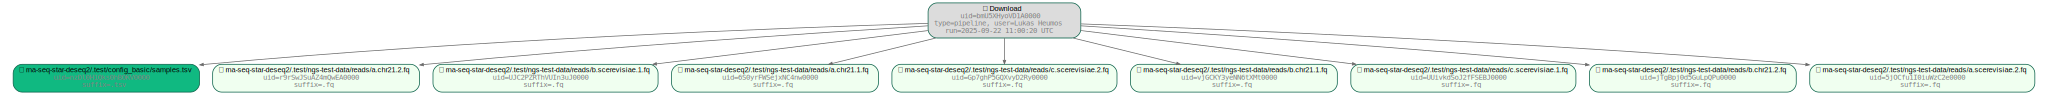

In [12]:
sample_sheet.view_lineage()

## Track Snakemake run

(We’d start here if input files were tracked in the cloud with LaminDB rather than downloaded through git.)

Track the Snakemake workflow & run:

In [14]:
transform = ln.Transform(
    name="snakemake-workflows/rna-seq-star-deseq2",
    version="2.0.0",
    type="pipeline",
    reference="https://github.com/laminlabs/snakemake-lamin-usecases",
)
ln.track(transform)
run = ln.context.run  # let's grab the global run record

If we now stage input files, they’ll be tracked as run inputs.

(In this test case, data is already locally available and staging won’t download anything.)

In [16]:
input_sample_sheet_path = sample_sheet.cache()
input_paths = [input_fastq.cache() for input_fastq in input_fastqs]

All data is now locally available, and we can run the snakemake pipeline:

In [17]:
!snakemake \
    --directory rna-seq-star-deseq2/.test \
    --snakefile rna-seq-star-deseq2/workflow/Snakefile \
    --configfile rna-seq-star-deseq2/.test/config_basic/config.yaml \
    --use-conda \
    --show-failed-logs \
    --cores 2 \
    --conda-frontend conda \
    --conda-cleanup-pkgs cache

## Register outputs

## QC

In [18]:
multiqc_file = ln.Artifact(f"{root_dir}/.test/results/qc/multiqc_report.html").save()

FileNotFoundError: /home/lukas/code/snakemake-lamin-usecases/docs/rna-seq-star-deseq2/.test/results/qc/multiqc_report.html

:::{dropdown} How would I register all QC files?

```python
multiqc_results = ln.File.from_dir(f"{root_dir}/results/qc/multiqc_report_data/")
ln.save(multiqc_results)
```

:::

## Count matrix

In [ ]:
count_matrix = ln.File(f"{root_dir}/.test/results/counts/all.symbol.tsv")
count_matrix.save()

## Track Snakemake ID

Snakemake does not have an easily accessible ID that is associated with a run.
Therefore, we need to extract it from the log files.
We're planning to simplify this process in the future.

In [ ]:
import pathlib
from datetime import datetime

PATH_TO_DOT_SNAKEMAKE_LOG = "rna-seq-star-deseq2/.test/.snakemake/log"
log_files_file_names = list(
    map(
        lambda lf: str(lf).split("/")[-1],
        list(pathlib.Path(PATH_TO_DOT_SNAKEMAKE_LOG).glob("*.snakemake.log")),
    )
)

timestamps = [
    datetime.strptime(filename.split(".")[0], "%Y-%m-%dT%H%M%S")
    for filename in log_files_file_names
]
snakemake_id = log_files_file_names[timestamps.index(max(timestamps))].split(".")[1]

Let us add the information about the session ID to our run record:

In [ ]:
run.reference = snakemake_id
run.reference_type = "snakemake_id"
run.save()

## Link biological entities

To make the count matrix queryable by biological entities (genes, experimental metadata, etc.), we can now proceed with: {doc}`docs:bulkrna`

## Visualize

View data lineage:

In [ ]:
count_matrix.view_flow()

View the database content:

In [ ]:
ln.view()

Clean up the test instance:

In [ ]:
!lamin delete --force snakemake-bulkrna